#Random Forest

##Import Package

In [1]:
pip install xlrd==1.2

     |████████████████████████████████| 103 kB 8.6 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import sklearn
from collections import defaultdict
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from numpy.lib.function_base import average

## Data Processing

In [180]:
df = pd.read_excel('default of credit card clients.xls', header = 1)
df.drop(columns = 'ID', inplace = True)

In [181]:
df = df[np.invert((df["EDUCATION"] == 0) | (df["MARRIAGE"] == 0)
                  |(df["EDUCATION"] == 5)|(df["EDUCATION"] == 6))]

df.loc[df['MARRIAGE'] == 1,'MARRIAGE'] = 'married'
df.loc[df['MARRIAGE'] == 2,'MARRIAGE'] = 'single'
df.loc[df['MARRIAGE'] == 3,'MARRIAGE'] = 'others'
df.reset_index(drop=True, inplace=True)
df = pd.get_dummies(df)
df_row = df.shape[0]
df_col = df.shape[1]
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,MARRIAGE_married,MARRIAGE_others,MARRIAGE_single
0,20000,2,2,24,2,2,-1,-1,-2,-2,...,0,689,0,0,0,0,1,1,0,0
1,120000,2,2,26,-1,2,0,0,0,2,...,0,1000,1000,1000,0,2000,1,0,0,1
2,90000,2,2,34,0,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0,0,1
3,50000,2,2,37,0,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,1,0,0
4,50000,1,2,57,-1,0,-1,0,0,0,...,2000,36681,10000,9000,689,679,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29596,220000,1,3,39,0,0,0,0,0,0,...,8500,20000,5003,3047,5000,1000,0,1,0,0
29597,150000,1,3,43,-1,-1,-1,-1,0,0,...,1837,3526,8998,129,0,0,0,0,0,1
29598,30000,1,2,37,4,3,2,-1,0,0,...,0,0,22000,4200,2000,3100,1,0,0,1
29599,80000,1,3,41,1,-1,0,0,0,-1,...,85900,3409,1178,1926,52964,1804,1,1,0,0


In [ ]:
# df = df[np.invert((df["EDUCATION"] == 0) | (df["MARRIAGE"] == 0)
#                   |(df["EDUCATION"] == 5)|(df["EDUCATION"] == 6))]

# df.loc[df['SEX'] == 1,'SEX'] = 'male'
# df.loc[df['SEX'] == 2,'SEX'] = 'female'
# df.loc[df['EDUCATION'] == 1,'EDUCATION'] = 'graduate'
# df.loc[df['EDUCATION'] == 2,'EDUCATION'] = 'university'
# df.loc[df['EDUCATION'] == 3,'EDUCATION'] = 'high'
# df.loc[df['EDUCATION'] == 4,'EDUCATION'] = 'others'
# df.loc[df['MARRIAGE'] == 1,'MARRIAGE'] = 'married'
# df.loc[df['MARRIAGE'] == 2,'MARRIAGE'] = 'single'
# df.loc[df['MARRIAGE'] == 3,'MARRIAGE'] = 'others'
# df.reset_index(drop=True, inplace=True)
# df = pd.get_dummies(df)
# df_row = df.shape[0]
# df_col = df.shape[1]
# df

##Data Splitting

In [184]:
X = df.iloc[:, df.columns != 'default payment next month']
y = df.iloc[:, df.columns == 'default payment next month']
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, random_state = 6, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 6, shuffle=True)

X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy().flatten()
y_valid = y_valid.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

X_tra_val = np.concatenate((X_train, X_valid), axis = 0)
y_tra_val = np.concatenate((y_train, y_valid), axis = 0)

##Random Forest

###Function Setup

####Loss Function

In [ ]:
def loss(y1, y2):
  # soft_accu = 1 - (y1 - y2[0]).mean()
  # print("soft accu:", soft_accu)

  round_y1 = np.where(y1 >= 0.5, 1, 0)
  hard_accu = (round_y1 == y2).mean()
  # print("hard accu:", hard_accu)

  return (1 - hard_accu)

####Depth Chosen

In [151]:
## Find the best level of random tree.
def alpha_opt(min_alpha, max_alpha, X_tr, y_tr, X_va, y_va):
  bestloss = float('inf')
  bestalpha = None
  alpha_que = deque()
  err_que = deque()

  for alpha in range(min_alpha, max_alpha):
    regr = RandomForestRegressor(max_depth=alpha, random_state=0, n_estimators=100)
    regr.fit(X_tr, y_tr)
    y_va_pred = regr.predict(X_va)
    ls = loss(y_va_pred, y_va.T)
    alpha_que.append(alpha)
    err_que.append(ls)

    print(alpha, ls)
    if ls < bestloss:
      bestloss = ls
      bestalpha = alpha
    
  plt.figure(figsize=(12,4)) 
  dots = sns.load_dataset("dots")
  sns.relplot(kind="line",
      x=alpha_que, y=err_que,
      facet_kws=dict(sharex=False))
  plt.title('Error Rate ~ Alpha')
  plt.show()
  return(bestalpha)

####Forest Size Chosen

In [152]:
## Find the best n estimators of random tree.
def n_est(bestalpha, max_n, X_tr, y_tr, X_va, y_va):
  bestn_loss = float('inf')
  bestn = None
  n_que = deque()
  err_que = deque()

  for n_est in range(1,max_n):
    regr_n = RandomForestRegressor(max_depth=bestalpha, random_state=0, n_estimators=n_est)
    regr_n.fit(X_tr, y_tr)
    y_va_pred_n = regr_n.predict(X_va)
    ls_n = loss(y_va_pred_n, y_va.T)
    n_que.append(n_est)
    err_que.append(ls_n)

    if ls_n < bestn_loss:
      bestn_loss = ls_n
      bestn = n_est

  plt.figure(figsize=(12,4)) 
  dots = sns.load_dataset("dots")
  sns.relplot(kind="line",
      x=n_que, y=err_que,
      facet_kws=dict(sharex=False))
  plt.title('Error Rate ~ N')
  plt.show()
  return(bestn)

####Shreshold Chosen

In [153]:
## Find the best threshold of random tree.
def threshold_est(y_te_pred, y_te):
  best_shre_loss = float('inf')
  best_shre = None
  i_que = deque()
  err_que = deque()

  i_list = np.linspace(0,1,101)
  for i in i_list:
    y_te_round = np.where(y_te_pred >= i, 1, 0)
    i_que.append(i)
    ls_shre = loss(y_te_round, y_te.T)
    err_que.append(ls_shre)

    if ls_shre < best_shre_loss:
        best_shre_loss = ls_shre
        best_shre = i

  plt.figure(figsize=(12,4)) 
  dots = sns.load_dataset("dots")
  sns.relplot(kind="line",
    x=i_que, y=err_que,
    facet_kws=dict(sharex=False))
  plt.title('Error Rate ~ Threshold')
  plt.show()
  return(best_shre)

### Model Selection

####Random Forest Model Introduction
Random forest is an Ensemble Learning algorithm belonging to the Bagging type. It combines multiple weak classifiers and votes or takes average values for the final results, so that the results of the overall model have high accuracy and generalization performance. Its good performance is mainly due to "randomness" and "forest", one making it resistant to overfitting, the other making it more accurate.

Besides, random forest is an algorithm based on random tree. Because of the nature of random tree, I skipped the process of standarlizing data, which did not have a big impact on tranining random forest model.

In the training of the model, I will test the depth of random trees, the number of random trees and the influence of shreshold used for classification on the accuracy of model prediction in turn. Finally, the most suitable model parameters for the current data set will be selected and compared with other models. 



1 0.1773648648648649
2 0.17837837837837833
3 0.17770270270270272
4 0.17837837837837833
5 0.17804054054054053
6 0.17635135135135138
7 0.17533783783783785
8 0.17635135135135138
9 0.17837837837837833


<Figure size 864x288 with 0 Axes>

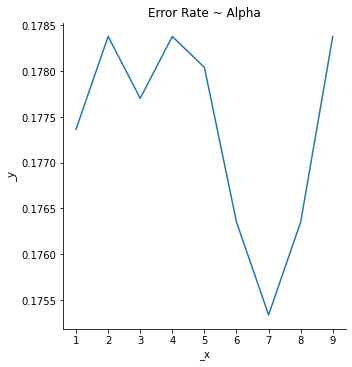

bestalpha 7


In [185]:
bestalpha = alpha_opt(1, 10, X_train, y_train, X_valid, y_valid)
print('bestalpha', bestalpha)

The figure presents a shape similar to Ushape. It can be found that for the current data set, the error rate obtained by the random forest with seven layers of depth is the minimum under the assumption that the number of fault trees is 100 and the default threshold is 0.5. However, we also found that by increasing the complexity from one tier to seven, the error rate actually decreased by 0.002, while the complexity might have increased by 64 times. Therefore, from the point of view of economic efficiency, choosing one or three layers is the most efficient, but we still set the optimal depth to 7 in order to achieve the maximum accuracy that the model can display.

<Figure size 864x288 with 0 Axes>

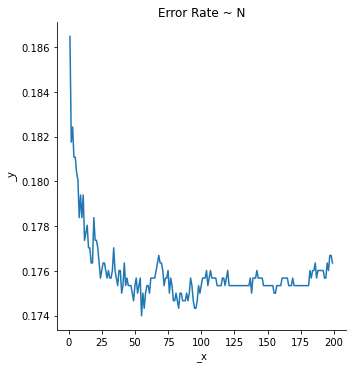

bestn 55


In [186]:
bestn = n_est(bestalpha, 200, X_train, y_train, X_valid, y_valid)
print('bestn', bestn)

Setting number of layers of depth to 7 and set the threshold equal to its default value 0.5, we have the above graph. From the graph, when the number of random trees increases from 1 to 50, the error rate has an obvious downward trend, While when the number of random trees increases from 50 to 200, the error rate fluctuates between 0.174 and 0.177, and even has a large rebound between 50 and 75. When the number of random trees approaches 200, the error rate has an increasing trend, which is abnormal. In general, more random trees mean more accurate predictions (we can reduce potential errors to some extent by increasing the number of random trees). Since there is generally no over-fitting problem in random forest, my guess here is that as the random tree increases, the error rate tends to a certain value, and its standard deviation will decrease to 0 as the number continues to increase, but the value approaching may not be the minimum error rate. But because of the limited operand, we may not know what that value is.

And we find that when the number of random trees is 55, the model reaches the minimum error rate. From the perspective of economic efficiency or the pursuit of a more accurate model, 55 is a reasonable choice. Therefore, 55 will be used for our final model.

<Figure size 864x288 with 0 Axes>

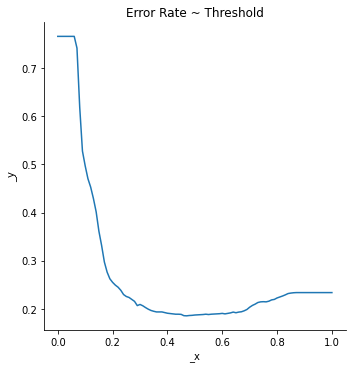

bestthreshold 0.47000000000000003


In [187]:
regr_best = RandomForestRegressor(max_depth=bestalpha, random_state=0, n_estimators=bestn)
regr_best.fit(X_tra_val, y_tra_val)
y_te_pred = regr_best.predict(X_test)

bestthre = threshold_est(y_te_pred, y_test)
print('bestthreshold', bestthre)

The figure shows a typical U shape. The error rate first dropped all the way from about 0.77 to around 0.18, and then rose slowly from 0.18 to 0.23. 

We should notice the error rate when threshold is equal to 0 or 1. These two numbers are very interesting. We find that about 77 percent of people do not delay payment, while about 23 percent do. Therefore, when threshold is equal to 0, it is equivalent to generalizing all people as the party that breaks the contract. So we would expect 77 percent of people to fall into the wrong category, which matches the result given by the graph. Similarly, when threshold is equal to 1, we sum up all the people as those who have not breached the contract. Therefore, it is expected that about 23 percent of the people will be classified into the wrong category, which also matches the result.


The best threshold is 0.47, around 0.5, which is also within a reasonable range. Therefore, 0.47 will be used in the final model training.

In [188]:
y_te_pred = np.where(y_te_pred >= bestthre, 1, 0)
print(classification_report(y_test, y_te_pred.T))
print('The Best Accuracy = ', average(y_te_pred.T == y_test))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2269
           1       0.69      0.38      0.49       692

    accuracy                           0.81      2961
   macro avg       0.76      0.66      0.69      2961
weighted avg       0.80      0.81      0.79      2961

The Best Accuracy =  0.8145896656534954


The accuracy of the new model trained after the above parameter selection is close to 81.5%. So it's a usable model, but certainly not the best model. Because that's actually only five percent more accurate than categorizing all people as non-defulat. But I believe the accuracy could be higher.

Part of the reason is that the data set has a small amount of data, which is less than 30000. If we had 100,000 or even a million data sets, we could expect a much higher and more accurate model. On the other hand, we have limited computational power, which makes it difficult to use the model to its fullest extent. In other words, limited computational power limits a more accurate models.